<a href="https://colab.research.google.com/github/ShaliniR8/HanaA/blob/master/Image_classifiction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow

**IMPORT LIBRARIES**

In [51]:
#@title Default title text
import tensorflow as tf
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
	os.mkdir('models')

print(os.path.isdir('models'))

print('Tensorflow version:', tf.__version__)

True
Tensorflow version: 2.2.0


**PREPROCESS DATA**

In [0]:
def get_three_classes(x, y):

    #selecting three classes out of all the class for practice
    indices_0, _ = np.where(y == 0.)
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)

    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [0]:
(x_train,y_train),(x_test,y_test)= tf.keras.datasets.cifar10.load_data()

In [66]:
print(x_train.shape,y_train.shape)
x_train, y_train = get_three_classes(x_train,y_train)
x_test , y_test= get_three_classes(x_test, y_test)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape )

(50000, 32, 32, 3) (50000, 1)
(15000, 32, 32, 3) (15000, 3) (3000, 32, 32, 3) (3000, 3)


**VISUALIZE EXAMPLES**

In [0]:
class_names=['aeroplanes', 'car' , 'bird' ]
def show_random_examples(x,y,p):
  indices = np.random.choice(range(x.shape[0]),10,replace=False)
  x=x[indices]
  y=y[indices]
  p=p[indices]

  plt.figure(figsize=(10,5))
  for i in range(10):
    plt.subplot(2,5,1+i)
    plt.imshow(x[i])
    #argmax returns index of max element in the numpy array
    col = 'green' if np.argmax(y[i])  == np.argmax(p[i]) else 'red'
    plt.xlabel(class_names[np.argmax(y[i])],color=col)
  plt.show()

#show_random_examples(x_train,y_train,y_train)

**CREATE MODEL**

In [68]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

#Conv2D -> Relu -> Batch Normalization -> Conv2D -> Max Pooling -> Dropout -> Flatten -> Dense
def create_model():
  def add_block(model, n_filters):
    model.add(Conv2D(n_filters,3,activation='relu',padding='same'))
    model.add(BatchNormalization())

    model.add(Conv2D(n_filters,3,activation='relu'))

    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.5))

    return model

  model=tf.keras.models.Sequential()
  #f=32, n_C=3
  model.add(Input(shape=(32,32,3)))
  model = add_block(model,32)
  model = add_block(model,64)

  model.add(Flatten())
  model.add(Dense(3, activation='softmax'))
  
  #compile
  model.compile( loss= 'categorical_crossentropy', optimizer='adam',
                metrics=['accuracy']
                )
  
  return model

model = create_model()
model.summary()







Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_8 (Batch (None, 15, 15, 64)       

**TRAIN MODEL**

In [69]:
h= model.fit(
    x_train/255,
    y_train,
    batch_size=120,
    epochs=10,
    validation_data=(x_test/255,y_test),
    callbacks=[
               
               tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3),
               tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5',
                                                 monitor='val_accuracy',
                                                 save_best_only=True,
                                                 save_weights_only=False
                                                 )
    ]
)

Epoch 1/10
125/125 [==============================] - 67s 539ms/step - loss: 0.8590 - accuracy: 0.6880 - val_loss: 2.4230 - val_accuracy: 0.3333
Epoch 2/10
125/125 [==============================] - 68s 542ms/step - loss: 0.5124 - accuracy: 0.7932 - val_loss: 2.9801 - val_accuracy: 0.3337
Epoch 3/10
125/125 [==============================] - 68s 547ms/step - loss: 0.4367 - accuracy: 0.8258 - val_loss: 1.9557 - val_accuracy: 0.4200
Epoch 4/10
125/125 [==============================] - 71s 566ms/step - loss: 0.3981 - accuracy: 0.8418 - val_loss: 0.7008 - val_accuracy: 0.7063
Epoch 5/10
125/125 [==============================] - 68s 542ms/step - loss: 0.3634 - accuracy: 0.8527 - val_loss: 0.4119 - val_accuracy: 0.8370
Epoch 6/10
125/125 [==============================] - 67s 538ms/step - loss: 0.3393 - accuracy: 0.8647 - val_loss: 0.3211 - val_accuracy: 0.8733
Epoch 7/10
125/125 [==============================] - 68s 546ms/step - loss: 0.3149 - accuracy: 0.8781 - val_loss: 0.3398 - val_ac

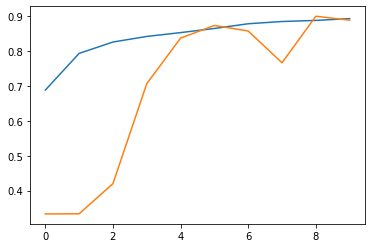

In [71]:
acc=h.history['accuracy']
val_acc=h.history['val_accuracy']

plt.plot(range(len(acc)),acc,label='Training accuracy')
plt.plot(range(len(val_acc)),val_acc,label='Validation accuracy')
plt.show()

In [0]:
model= tf.keras.models.load_model('models/model_0.900.h5')

In [0]:
pred=model.predict(x_test/255)

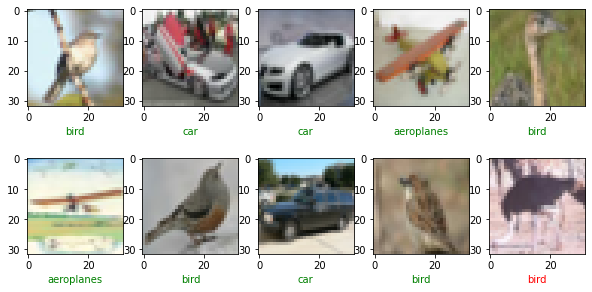

In [81]:
show_random_examples(x_test,y_test,pred)